In [16]:
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from sklearn.utils import shuffle

from config import efficientNet_config
from models import efficientNetV2B0_model, efficientNetV2B3_model
from utils import plt_heatmap, plt_roccurve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import os
# 使用第二張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [17]:
height  = efficientNet_config['height_B0']
width   = efficientNet_config['width_B0']

# 載入測試資料

In [18]:
# test_dir      = '../dataset_smooth_186video_20230323/test'    # !!!!!!!!!!!!!!!
test_dir      = '../dataset_186video_20230323/test'           # !!!!!!!!!!!!!!!

# test_dir      = '../dataset_smooth_22video_20221031/test/'  ##　這邊改資料集
# test_dir      = '../dataset_smooth_22video_20221031/train/'
# test_dir      = '../dataset_smooth_22video_20221031/validation/'
test_img_arrays = []
test_img_labels = []
test_img_names  = []

## test
img_paths = glob(test_dir + "/0/*.png")
for img_path in img_paths:
    # image
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array,(height,width))     # resize to (224,224)
    test_img_arrays.append(img_array)
    # label
    test_img_labels.append([0])
    # name
    test_img_names.append(img_path.split("/")[-1])

img_paths = glob(test_dir + "/1/*.png")
for img_path in img_paths:
    # image
    img_array = cv.imread(img_path)
    img_array = cv.resize(img_array,(height,width))      # resize to (224,224)
    test_img_arrays.append(img_array)
    # label
    test_img_labels.append([1])
    # name
    test_img_names.append(img_path.split("/")[-1])

In [19]:
test_img_arrays = np.array(test_img_arrays)
test_img_labels = np.array(test_img_labels)

In [20]:
print("測試集維度= ", test_img_arrays.shape)

測試集維度=  (2949, 224, 224, 3)


# 載入模型

In [21]:
model = efficientNetV2B0_model()
model.load_weights('../model/202303/20230401.weights')

# 最後一個epoch的模型
# from tensorflow import keras
# model = keras.models.load_model('../model/202303/20230401_lastepoch.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


# 打亂

In [22]:
# test_img_arrays, test_img_labels = shuffle(test_img_arrays,test_img_labels)

In [23]:
# test_img_arrays.shape

# 預測

In [24]:
pred_result = model.predict(test_img_arrays)

93/93 [==============================] - 3s 24ms/step


# 結果

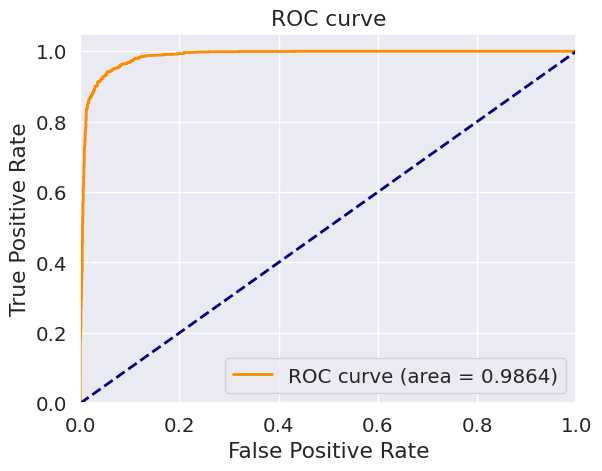

In [25]:
fpr, tpr, thresholds = roc_curve(test_img_labels, pred_result, pos_label=1) 
roc_auc = auc(fpr, tpr)
plt_roccurve(fpr,tpr,roc_auc)

In [26]:
pred_result = np.where(pred_result > 0.5, 1,0)
tn, fp, fn, tp = confusion_matrix(test_img_labels, pred_result).ravel()
sensitivity = round(tp / (tp+fn), 4)
specificity = round(tn / (tn+fp), 4)
balanced_acc= round((sensitivity+specificity)/2, 4)
precision   = round(tp / (tp+fp), 4)
f1score     = round(2/((1/precision)+(1/sensitivity)), 4)
accuracy    = round((tp+tn)/(tn+fp+fn+tp), 4)

print('Sensitivity= ',sensitivity)
print('Specificity= ',specificity)
print('Balanced_acc= ',balanced_acc)
print('Precision= ', precision)
print('f1score= ', f1score)
print('Accuracy= ',accuracy)

Sensitivity=  0.9519
Specificity=  0.9297
Balanced_acc=  0.9408
Precision=  0.9295
f1score=  0.9406
Accuracy=  0.9407


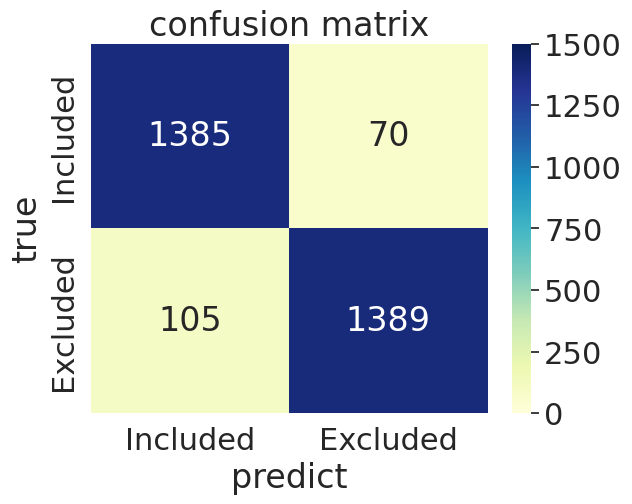

In [27]:
plt_heatmap([[tp,fn],[fp,tn]])

# 把stage1結果存起來，給stage2用

In [28]:
test_dict = {
 "test_name" : test_img_names,
 "test_true" : test_img_labels.reshape(-1),
 "stage1_test_pred" : pred_result.reshape(-1)
}


In [29]:
# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_test_20230323.pickle")
# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_test.pickle")
# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_test_nosmooth.pickle")

# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_train.pickle")
# pd.DataFrame(test_dict).to_pickle("../result/stage1_pred_result_validation.pickle")

In [30]:
pd.DataFrame(test_dict)

,test_name,test_true,stage1_test_pred
0,20210305_00001.png,0,0
1,20210305_00002.png,0,0
2,20210305_00003.png,0,0
3,20210305_00004.png,0,0
4,20210305_00005.png,0,0
...,...,...,...
2944,20210305_00052.png,1,1
2945,20210305_00053.png,1,1
2946,20210305_00054.png,1,1
2947,20210305_00055.png,1,1
